# Multiple polarization simulation
GenSol integration with Nazca also support simulation of components involving multiple modes. This is a little tricker than simulation involving only one mode, mainly due to the difference in which Nazca and GenSol keep tracks of the different modes. In particular:
- for **GenSol** two modes at the same port are effectively two separate ports, with no relation to each other. The fact that a few ports may share the same physical position is irrelevant (no geometry position is considered in **GenSol**).
- **Nazca** store the physical the connection. Only one pin exist for all the modes that refer to the same physical port. The number of modes at the port is stored inside the `xSection` of the pin. 
For this reasons, the 1 to 1 mapping between **Nazca** pins and **GenSol** ports fails when multiple polarization are involved. To solve this, the `get_solver` function will automatically add ports to the solver then multiple modes are detected. For example, if a **Nazca** pin named 'a0' has three modes, identified by the integers '0','1', and '3', the solver will actually have 3 pins: 'a0_pol0', 'a0_pol1', and 'a0_pol3'.

**NOTE:** Since different modes in a waveguide usually corresponds to multiple polarizations, the two terms will be used interchangingly in this documents, and they will be called polarization (or `pol`) in the code. 
 
## Setting up
In order to show some example, we need to create an `xSection` object with multiple modes. The easies way is just to change the `pol_list` attribute of `xsShallow` in demofab. The  default (`None`) is here changed to (`[0,1]`), giving the xSection to modes. In order to give the two modes different effective indexes, the default `Neff` of the xSection is also overwritten with a custom defined function. in the future the `Neff` could be taken directly from solvers or set though compact models. Also, the model of the MMI will be changed, in order to make it a polarization insensitive beam splitter.

In [1]:
import nazca as nd
from nazca import demofab as demo
import solver as sv
import numpy as np
import matplotlib.pyplot as plt

def func(wl=None,w=None,R=None,pol=None):
    return 2.0+0.5*pol

demo.xsShallow.pol_list=[0,1]
demo.xsShallow.set_Neff(func)

MMI=demo.mmi2x2_sh()
MMI.model_info['model']=sv.GeneralBeamSplitter(ratio=0.5,phase=0.5).expand_pol([0,1])

INFO: netlist.py: set pin2pin drc on: True


## Single waveguide
In the following the standard example of the simple straight waveguide is presented. As can be see, since now `xsShallow` has 2 modes, a total of 4 (2 modes x 2 ports) are created for the waveguide. The transmission matrix is as expected (each mode in the input port go to the same mode in the output port).

/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


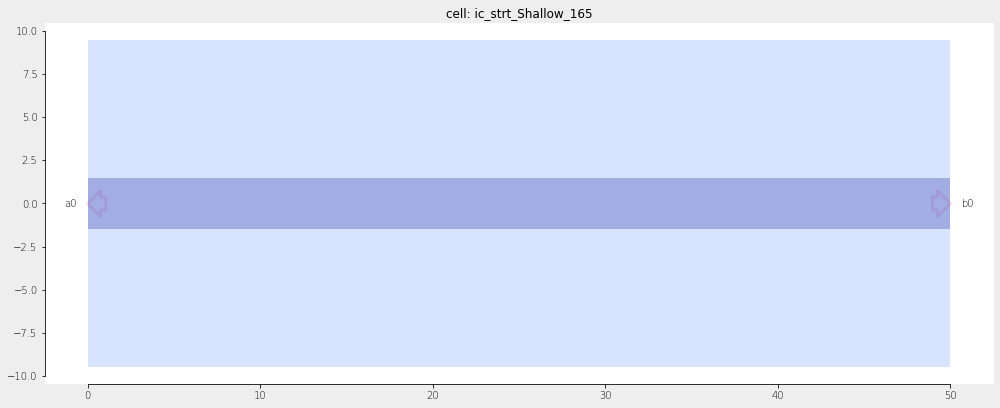

Free pins of solver: Solver of ic_strt_Shallow_165 (id=140343695803952))
(Structure (id=140343693331704) containing Model object (id=140343686286024) with pins: ['a0_pol0', 'b0_pol0', 'a0_pol1', 'b0_pol1'], a0_pol0) --> a0_pol0
(Structure (id=140343693331704) containing Model object (id=140343686286024) with pins: ['a0_pol0', 'b0_pol0', 'a0_pol1', 'b0_pol1'], b0_pol0) --> b0_pol0
(Structure (id=140343693331704) containing Model object (id=140343686286024) with pins: ['a0_pol0', 'b0_pol0', 'a0_pol1', 'b0_pol1'], a0_pol1) --> a0_pol1
(Structure (id=140343693331704) containing Model object (id=140343686286024) with pins: ['a0_pol0', 'b0_pol0', 'a0_pol1', 'b0_pol1'], b0_pol1) --> b0_pol1

Transmission Matrix
          a0_pol0   a0_pol1
b0_pol0    1.0000    0.0000
b0_pol1    0.0000    1.0000


In [2]:
e=demo.shallow.strt(50.0)
nd.export_plt(topcells=e)

S=nd.get_solver(e)
S.show_free_pins()

M=S.solve(wl=1.55)
print('Transmission Matrix')
print( '          a0_pol0   a0_pol1')
print(f"b0_pol0   {M.get_T('a0_pol0','b0_pol0'):7.4f}   {M.get_T('a0_pol1','b0_pol0'):7.4f}")
print(f"b0_pol1   {M.get_T('a0_pol0','b0_pol1'):7.4f}   {M.get_T('a0_pol1','b0_pol1'):7.4f}")


In order to actually see the difference in the effective indexes of the different modes, here is a plot of the phase evolution as a function of wavelength for the different modes:

Text(0, 0.5, 'Phase')

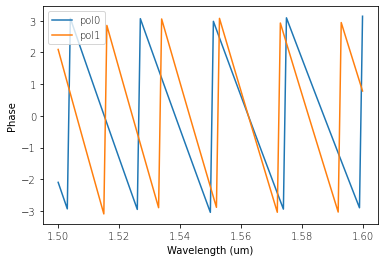

In [3]:
wll=np.linspace(1.5,1.6,101)
PS_pol0=[S.solve(wl=wl).get_PH('a0_pol0','b0_pol0') for wl in wll]
PS_pol1=[S.solve(wl=wl).get_PH('a0_pol1','b0_pol1') for wl in wll]

plt.plot(wll,PS_pol0, label='pol0')
plt.plot(wll,PS_pol1, label='pol1')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel('Phase')

## Dual Polarization Mach-Zhender
One the basic are estabilished, more complex circuits can be modelled just like the single mode case. For example, here is an unbalanced Mach-Zehnder interferomentes. Note that since the model of a dual polarization thermal phase shifter is not available in the **SolGen** basic models, it will be build now. 

INFO: layout.py: Added color to ShallowIcon, (1, 20, None)
INFO: layout.py: Added color to ShallowStub, (1, 10, None)
INFO: layout.py: Added color to ShallowTrenchStub, (2, 10, None)


/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


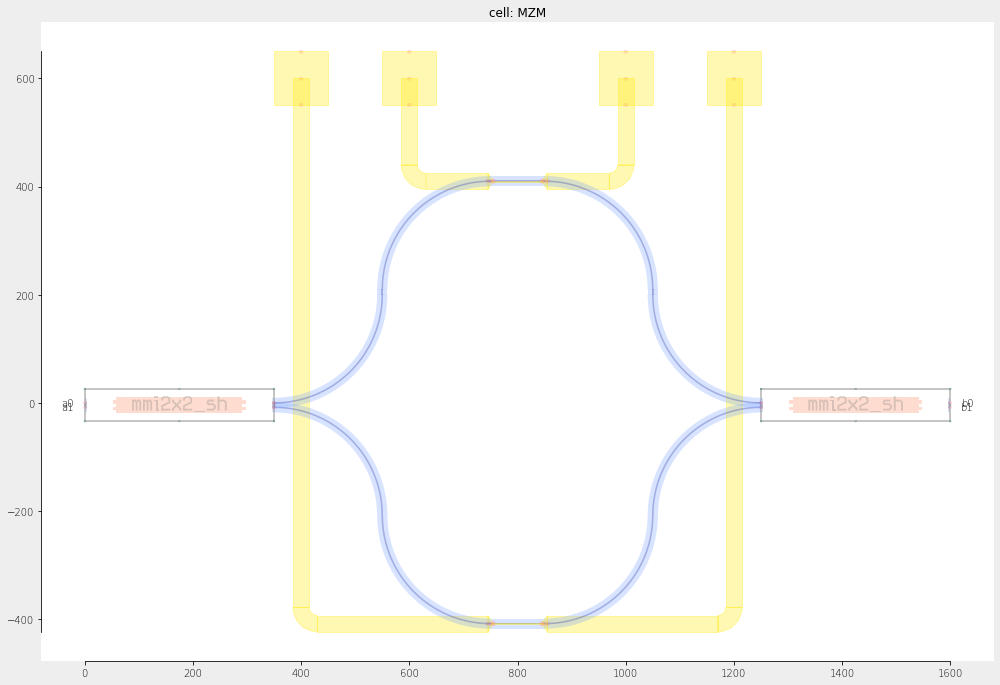

Free pins of solver:                 Solver of MZM (id=140343483623912))
(Structure (id=140343483659264) containing Model of beam-splitter with ratio 0.5 (id=140343483659208), a0_pol0) --> a0_pol0
(Structure (id=140343483659264) containing Model of beam-splitter with ratio 0.5 (id=140343483659208), a1_pol0) --> a1_pol0
(Structure (id=140343483659264) containing Model of beam-splitter with ratio 0.5 (id=140343483659208), a0_pol1) --> a0_pol1
(Structure (id=140343483659264) containing Model of beam-splitter with ratio 0.5 (id=140343483659208), a1_pol1) --> a1_pol1
(Structure (id=140343483807056) containing Model of beam-splitter with ratio 0.5 (id=140343483807000), b0_pol0) --> b0_pol0
(Structure (id=140343483807056) containing Model of beam-splitter with ratio 0.5 (id=140343483807000), b1_pol0) --> b1_pol0
(Structure (id=140343483807056) containing Model of beam-splitter with ratio 0.5 (id=140343483807000), b0_pol1) --> b0_pol1
(Structure (id=140343483807056) containing Model of beam-sp

Text(0, 0.5, 'Transmission')

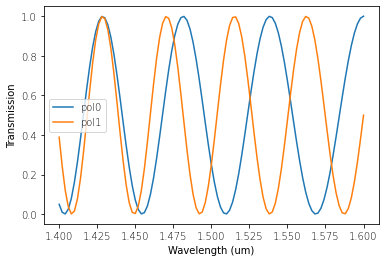

In [4]:
with nd.Cell(name='PhaseShifter') as PS:
    t1=demo.metaldc.taper(width2=2.0,length=10.0).put()
    demo.metaldc.strt(90.0,width=2.0).put()
    t2=demo.metaldc.taper(width1=2.0,length=10.0).put()
    
    wg=demo.shallow.strt(100.0).put(5.0,0.0,0.0)
    
    nd.Pin('c0',pin=t1.pin['a0']).put()
    nd.Pin('c1',pin=t2.pin['b0']).put()
    nd.Pin('a0',pin=wg.pin['a0']).put()
    nd.Pin('b0',pin=wg.pin['b0']).put()
    
    with sv.Solver(name='Multipol_ps') as SOL:
        WGm=sv.MultiPolWave(90.0,demo.xsShallow.Neff,pol_list=[0,1])
        PSm=sv.PhaseShifter().expand_pol(pol_list=[0,1])
        wg=WGm.put()
        ps=PSm.put()

        sv.connect(wg.pin['b0_pol0'],ps.pin['a0_pol0'])
        sv.connect(wg.pin['b0_pol1'],ps.pin['a0_pol1'])
        
        sv.Pin('a0_pol0').put(wg.pin['a0_pol0'])
        sv.Pin('a0_pol1').put(wg.pin['a0_pol1'])
        sv.Pin('b0_pol0').put(ps.pin['b0_pol0'])
        sv.Pin('b0_pol1').put(ps.pin['b0_pol1'])


    PS.model_info['model']=SOL
    
with nd.Cell(name='DC_pad') as DCp:
    demo.metaldc.strt(100.0,width=100.0).put(-50.0,0,0)
    nd.Pin('a0',xs=demo.metaldc.xs).put(0,0,90.0)
    

with nd.Cell(name='MZM') as MZM_bal:
    m1=MMI.put()
    demo.shallow.sbend(offset=410.0).put()
    ps=PS.put(param_mapping={'PS': 'PS1'})
    demo.shallow.sbend(offset=-410.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-400.0).put(m1.pin['b1'])
    ps2=PS.put(param_mapping={'PS': 'PS2'})
    demo.shallow.sbend(offset=400.0).put()
    
    DCp.put(600.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c0']).put()
    DCp.put(1000.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c1']).put()

    DCp.put(400.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c0']).put()
    DCp.put(1200.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c1']).put()
    
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('a1',pin=m1.pin['a1']).put()
    nd.Pin('b0',pin=m2.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['b1']).put()
    
nd.export_plt(topcells=MZM_bal)

sol=nd.get_solver(MZM_bal)

sol.show_free_pins()

wll=np.linspace(1.4,1.6,101)
T0_1=[sol.solve(wl=wl,PS1=0.0,PS2=0.0).get_T('a0_pol0','b0_pol0') for wl in wll]
T1_1=[sol.solve(wl=wl,PS1=0.0,PS2=0.0).get_T('a0_pol1','b0_pol1') for wl in wll]

plt.plot(wll,T0_1, label='pol0')
plt.plot(wll,T1_1, label='pol1')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel('Transmission')


As can be seen for the output, the MZM solver now has 8 ports (4 ports x 2 modes). As can be seen, the spacing between the fringes is different for the two modes, due the different effective indexes. Off course, this can be combined with the usual setting of the parameters. For example in the following the 'pol1' spectrum has ben calculated by adding a $\pi/2$ shift to one of the arms. 

Text(0, 0.5, 'Transmission')

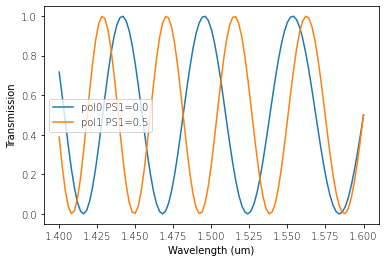

In [5]:
wll=np.linspace(1.4,1.6,101)
T0_1=[sol.solve(wl=wl,PS1=0.0).get_T('a0_pol0','b0_pol0') for wl in wll]
T0_1=[sol.solve(wl=wl,PS1=0.5).get_T('a0_pol0','b0_pol0') for wl in wll]

plt.plot(wll,T0_1, label='pol0 PS1=0.0')
plt.plot(wll,T1_1, label='pol1 PS1=0.5')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel('Transmission')


## Polarization rotator
Custom model could be inserted to simulate the desired polarization behavior of each component. For example, here is a cell for a 90$^{\circ}$ polarization rotator (graphically represented as a wider straight waveguide).

In [6]:
PolRot=demo.shallow.strt(50.0, width=5.0)
PolRot.model_info['model']=sv.PolRot(angle=0.5)

S=nd.get_solver(PolRot)
#S.show_free_pins()

M=S.solve(wl=1.55)
print('Transmission Matrix')
print( '          a0_pol0   a0_pol1')
print(f"b0_pol0   {M.get_T('a0_pol0','b0_pol0'):7.4f}   {M.get_T('a0_pol1','b0_pol0'):7.4f}")
print(f"b0_pol1   {M.get_T('a0_pol0','b0_pol1'):7.4f}   {M.get_T('a0_pol1','b0_pol1'):7.4f}")

Transmission Matrix
          a0_pol0   a0_pol1
b0_pol0    0.0000    1.0000
b0_pol1    1.0000    0.0000


## Ring with polarization rotator
Just out of curiosity, let's try to insert the polarization rotator inside a ring resonator:

ERROR: netlist.py: DRC-1: width mismatch in cell 'Ring_PR': 3.0 != 5.0 : ic_bend_Shallow_237.pin['b0'] - ic_strt_Shallow_234.pin['a0'] @ (550.000, 208.000)
ERROR: netlist.py: DRC-2: width mismatch in cell 'Ring_PR': 5.0 != 3.0 : ic_strt_Shallow_234.pin['b0'] - ic_bend_Shallow_240.pin['a0'] @ (550.000, 258.000)


/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


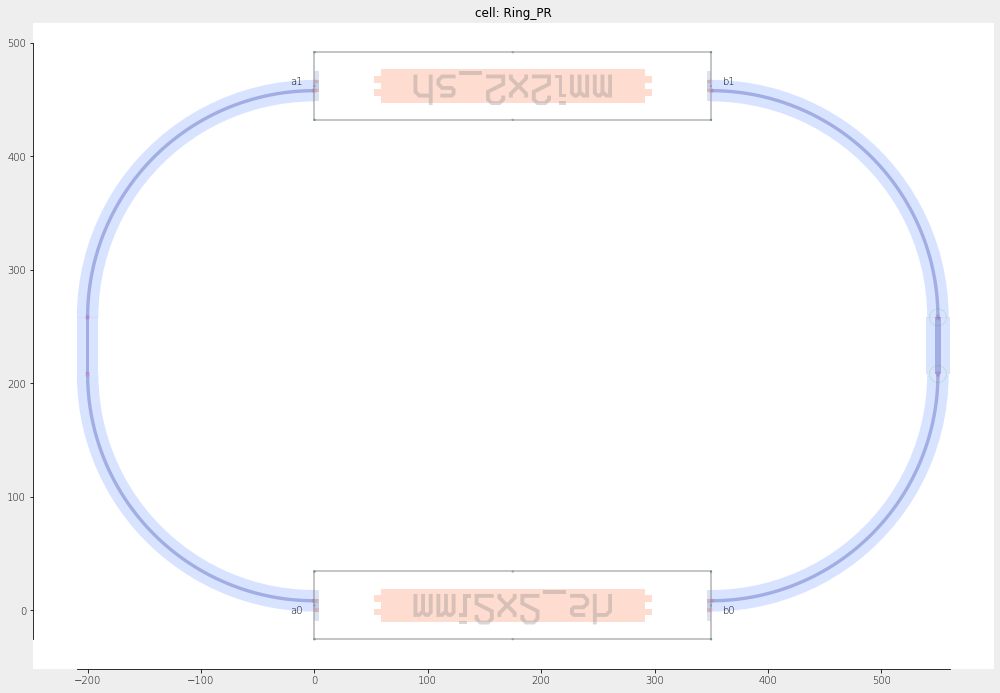

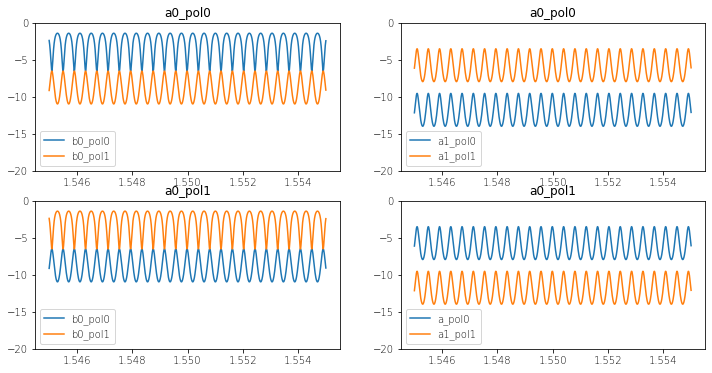

In [7]:
with nd.Cell(name='Ring_PR') as R:
    m1=MMI.put(flip=True)
    demo.shallow.bend(angle=90.0).put(m1.pin['b1'])
    PolRot.put()
    demo.shallow.bend(angle=90.0).put()
    m2=MMI.put()
    demo.shallow.bend(angle=90.0).put()
    #PolRot.put()
    demo.shallow.strt(50.0).put()
    demo.shallow.bend(angle=90.0).put()
    
    
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('b0',pin=m1.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['a1']).put()
    nd.Pin('a1',pin=m2.pin['b1']).put()
    
nd.export_plt(topcells=R)

Sol=nd.get_solver(R)

wll=np.linspace(1.545,1.555,1001)
T=[]
for wl in wll:
    M=Sol.solve(wl=wl)
    T.append((M.get_T('a0_pol0','b0_pol0'),M.get_T('a0_pol0','b0_pol1'),
              M.get_T('a0_pol0','a1_pol0'),M.get_T('a0_pol0','a1_pol1'),
              M.get_T('a0_pol1','b0_pol0'),M.get_T('a0_pol1','b0_pol1'),
              M.get_T('a0_pol1','a1_pol0'),M.get_T('a0_pol1','a1_pol1'),
             ))

    
fig, ax = plt.subplots(2, 2, figsize=[12.0, 6.0])    
ax[0,0].plot(wll,[10*np.log10(t[0]) for t in T], label='b0_pol0')
ax[0,0].plot(wll,[10*np.log10(t[1]) for t in T], label='b0_pol1')
ax[0,0].set_ylim(-20,0)
ax[0,0].set_title('a0_pol0')
ax[0,0].legend()


ax[0,1].plot(wll,[10*np.log10(t[2]) for t in T], label='a1_pol0')
ax[0,1].plot(wll,[10*np.log10(t[3]) for t in T], label='a1_pol1')
ax[0,1].set_ylim(-20,0)
ax[0,1].set_title('a0_pol0')
ax[0,1].legend()

ax[1,0].plot(wll,[10*np.log10(t[4]) for t in T], label='b0_pol0')
ax[1,0].plot(wll,[10*np.log10(t[5]) for t in T], label='b0_pol1')
ax[1,0].set_ylim(-20,0)
ax[1,0].set_title('a0_pol1')
ax[1,0].legend()

ax[1,1].plot(wll,[10*np.log10(t[6]) for t in T], label='a_pol0')
ax[1,1].plot(wll,[10*np.log10(t[7]) for t in T], label='a1_pol1')
ax[1,1].set_ylim(-20,0)
ax[1,1].set_title('a0_pol1')
ax[1,1].legend()

    